In [1]:
# import all necessay library
%time
import numpy as np
from numpy import linalg as LA
from functions import ClusterMerits, AuxiliarFunctions
from sklearn import preprocessing
from sklearn.datasets.samples_generator import make_blobs
from scipy.stats import norm
import matplotlib.mlab as mlab
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


In [2]:
# load the data and little data
%time
data_path = '/home/micael/MyWorkspace/DATA'
signal = np.load(data_path+'/'+'lvbb125Matrix.npy')[0:5000,:]
signal_scd = preprocessing.scale(signal)
signal_part = np.load(data_path+'/'+'lvbb125Matrix.npy')[0:250,:]
signal_trgt = np.ones(signal.shape[0])

ttbar = np.load(data_path+'/'+'TTbarMatrix.npy')
ttbar_scd = preprocessing.scale(ttbar)
ttbar_part = np.load(data_path+'/'+'TTbarMatrix.npy')[0:250,:]
bkg = ttbar
bkg_trgt = np.zeros(bkg.shape[0])

data = np.append(signal,bkg,axis=0)
data_scd = np.append(signal_scd,ttbar_scd,axis=0)
little_data = np.append(signal_part,ttbar_part,axis=0)
trgt = np.append(signal_trgt,bkg_trgt,axis=0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs


In [3]:
# shuffle the little data
np.random.shuffle(little_data)

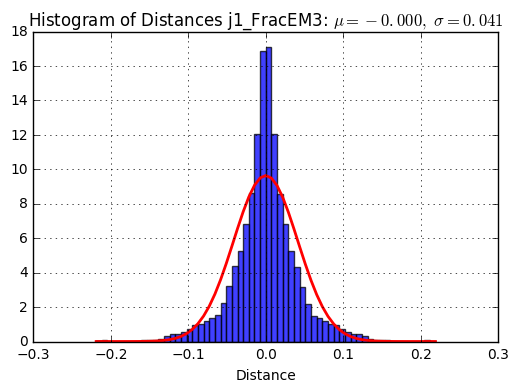

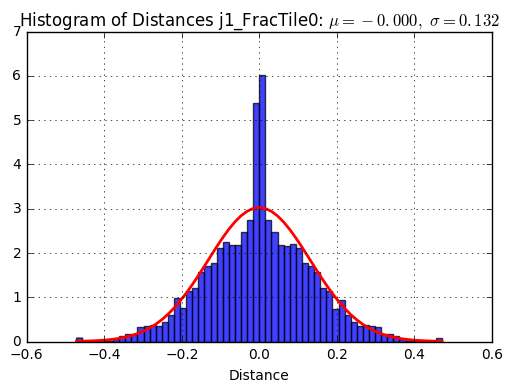

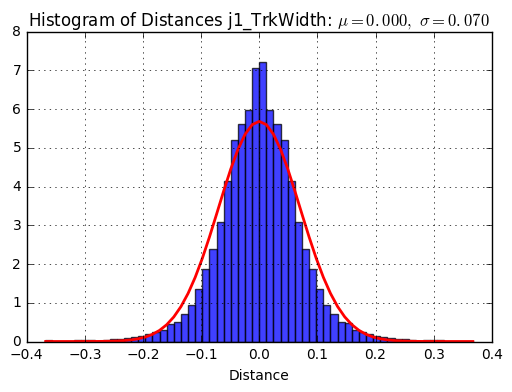

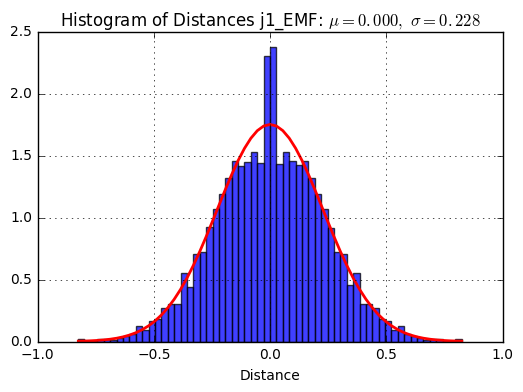

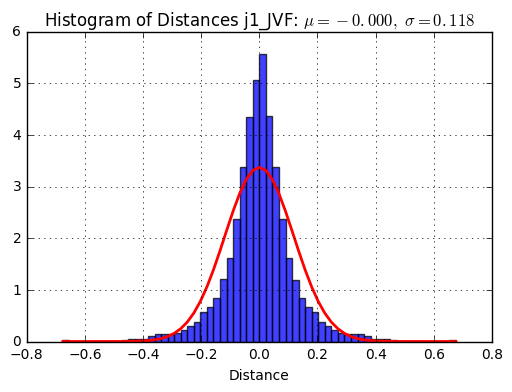

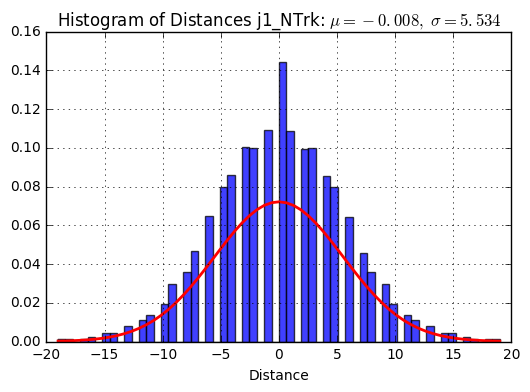

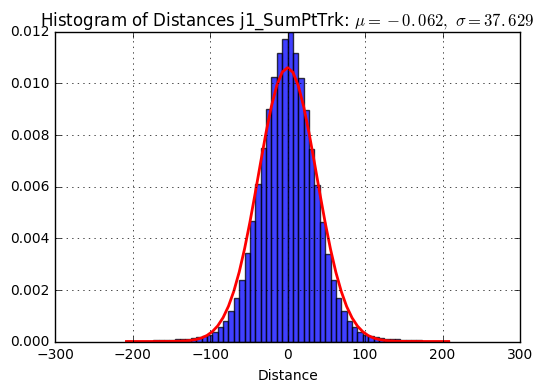

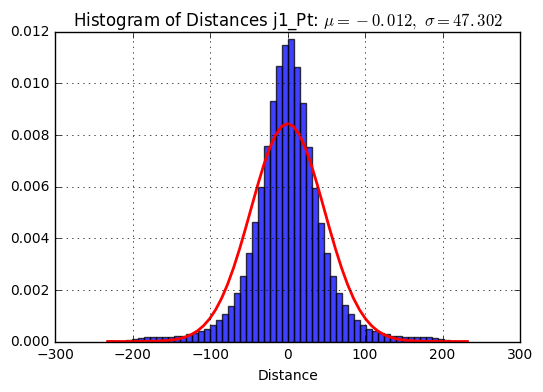

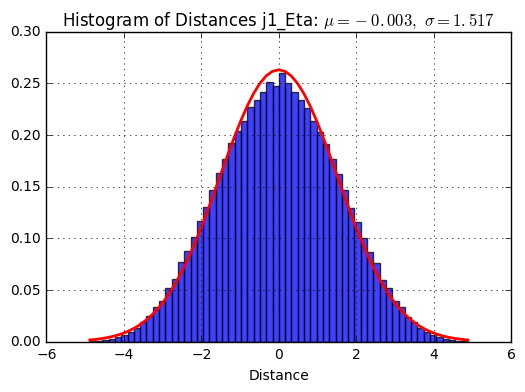

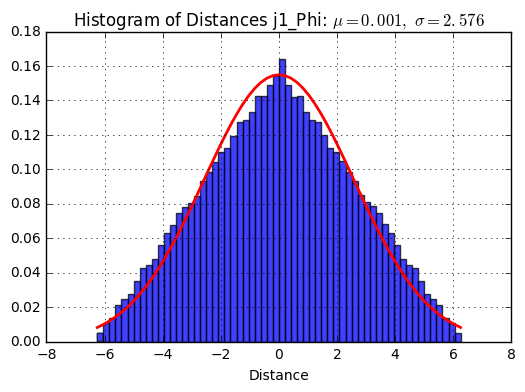

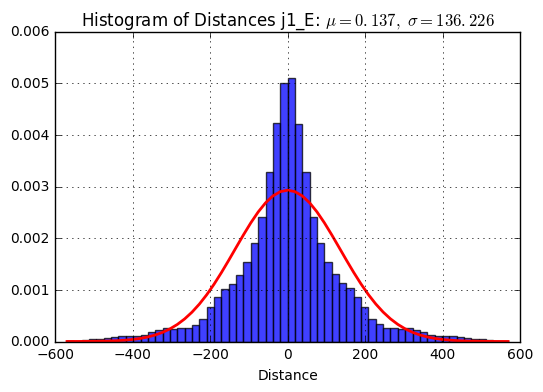

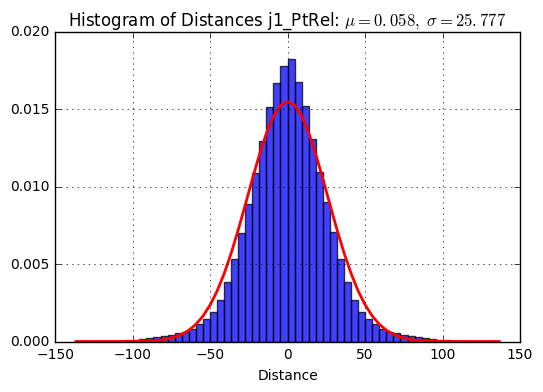

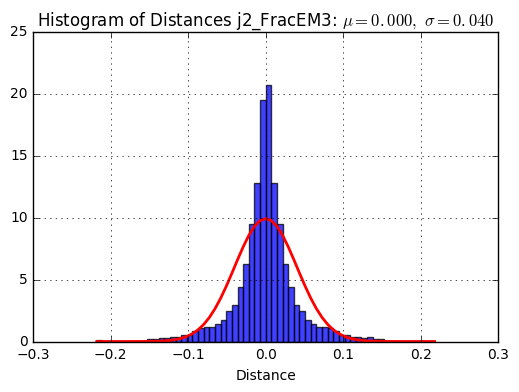

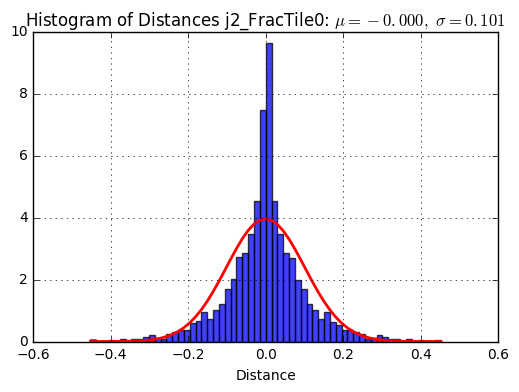

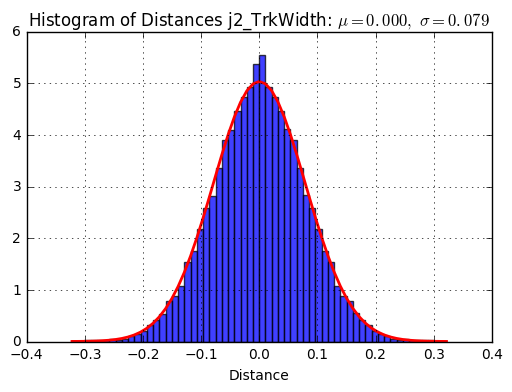

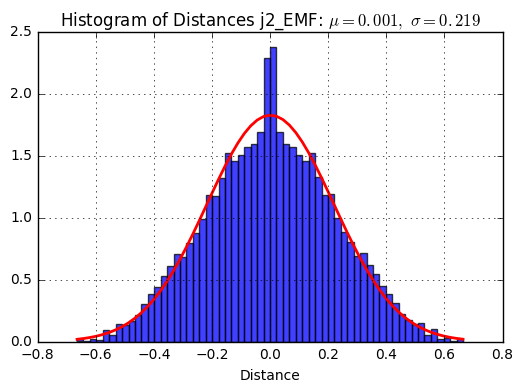

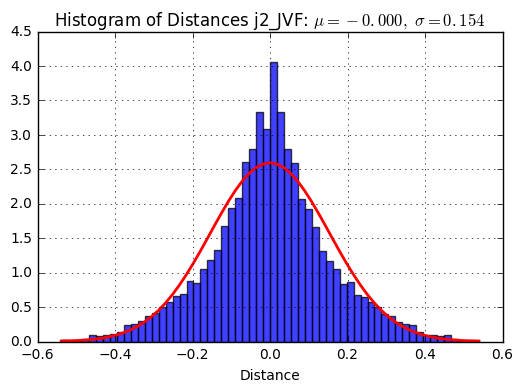

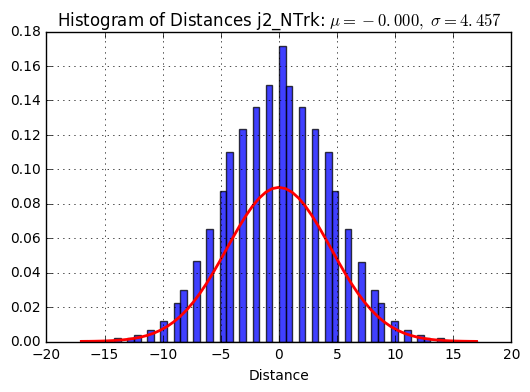

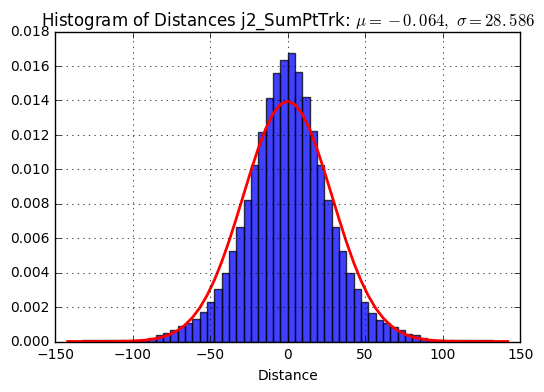

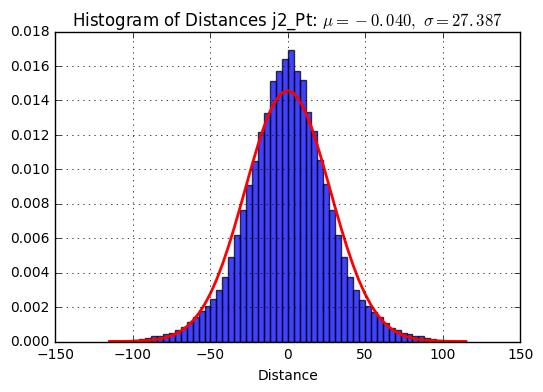

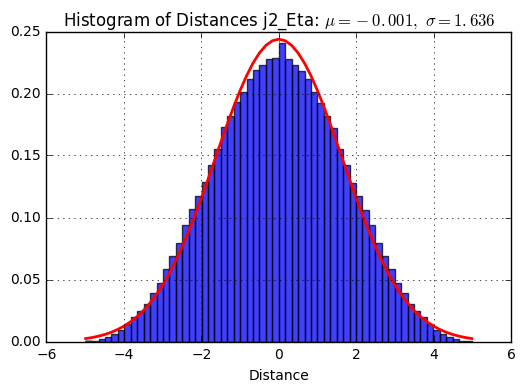

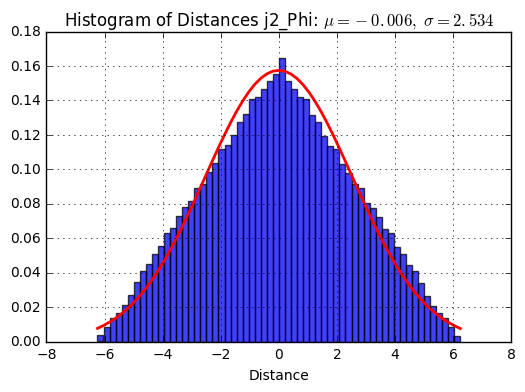

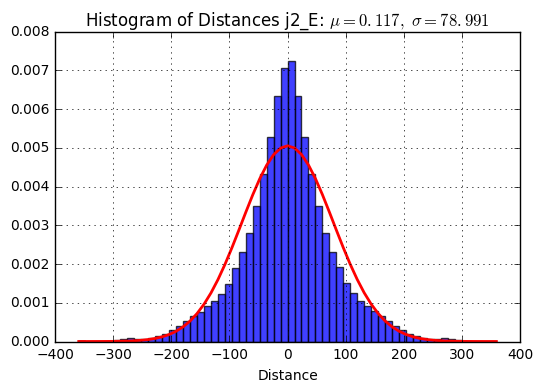

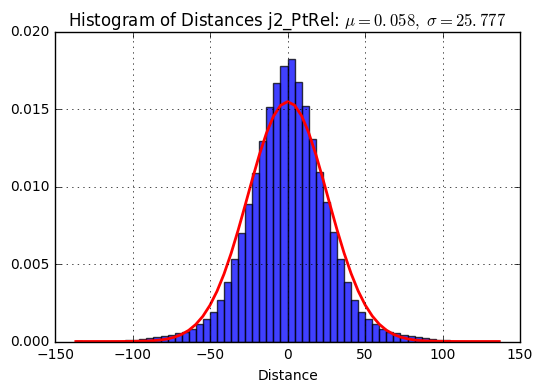

In [4]:
# distance histograms - use to estimate the sigma | better way?
variables = "j1_FracEM3,j1_FracTile0,j1_TrkWidth,j1_EMF,j1_JVF,j1_NTrk,j1_SumPtTrk,j1_Pt,j1_Eta,j1_Phi,j1_E,j1_PtRel,j2_FracEM3,j2_FracTile0,j2_TrkWidth,j2_EMF,j2_JVF,j2_NTrk,j2_SumPtTrk,j2_Pt,j2_Eta,j2_Phi,j2_E,j2_PtRel"
for variable,k in zip(variables.split(','),range(little_data.shape[1])):
    
    for i in range(little_data.shape[0]-1):
        for j in range(little_data.shape[0]):
            dist0 = little_data[i,k]-little_data[j,k]
            #dist1 = abs(little_data[i,k]-little_data[j,k])
            dataBuffer0 = np.array([dist0])
            #dataBuffer1 = np.array([dist1])
            if i==0:
                data0 = dataBuffer0
                #data1 = dataBuffer1
            else:
                data0 = np.append(data0,dataBuffer0, axis=0)
                #data1 = np.append(data1,dataBuffer1, axis=0)
            
    # best fit of data
    (mu, sigma) = norm.fit(data0)
    
    n, bins, patches = plt.hist(data0, 60, normed=1, facecolor='blue', alpha=0.75)
    # add a 'best fit' line
    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'r', linewidth=2)
    #plt.xlim()
    #plot
    plt.xlabel('Distance')
    #plt.xlim(-sigma,sigma)
    plt.ylabel('')
    plt.title(r'Histogram of Distances '+variable+': $\mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
    plt.grid(True)

    plt.show()

In [2]:
# random data set for testing 

n_samples=200
n_features=2
centers=[[-2,-2],[2,2]] 
cluster_std=1.0

X, y = make_blobs(n_samples, n_features, centers, cluster_std,
                  random_state=None)
#X,y

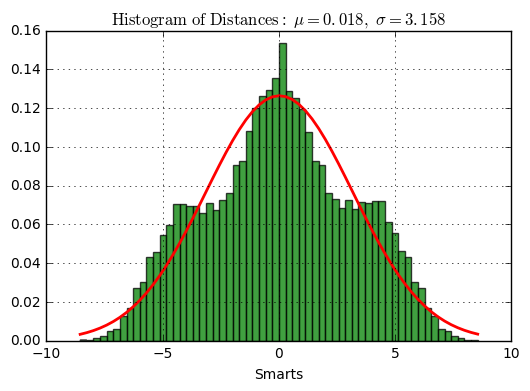

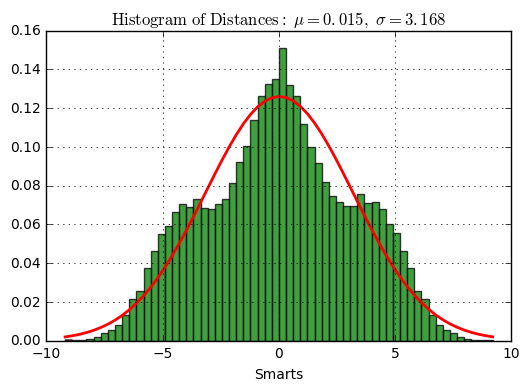

In [6]:


for k in range(X.shape[1]):
    
    for i in range(X.shape[0]-1):
        for j in range(X.shape[0]):
            dist0 = X[i,k]-X[j,k]
            dist1 = abs(X[i,k]-X[j,k])
            dataBuffer0 = np.array([dist0])
            dataBuffer1 = np.array([dist1])
            if i==0:
                data0 = dataBuffer0
                data1 = dataBuffer1
            else:
                data0 = np.append(data0,dataBuffer0, axis=0)
                data1 = np.append(data1,dataBuffer1, axis=0)
    # best fit of data
    (mu1, sigma1) = norm.fit(data0)
    
    n, bins, patches = plt.hist(data0, 60, normed=1, facecolor='green', alpha=0.75)
    # add a 'best fit' line
    y = mlab.normpdf( bins, mu1, sigma1)
    l = plt.plot(bins, y, 'r', linewidth=2)

    #plot
    plt.xlabel('Smarts')
    plt.ylabel('')
    plt.title(r'$\mathrm{Histogram\ of\ Distances:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu1, sigma1))
    plt.grid(True)

    plt.show()
    #plt.subplot(211)
    #print 'desvio padrao ', np.std(data0)
    #plt.hist(data0,bins=60)
    #plt.subplot(212)
    #plt.hist(data1,bins=60)
    #plt.show()

In [3]:
# calculate the centers using ClusterMerits

C_1 = ClusterMerits.Baricenter(X[y==0,:])
C_2 = ClusterMerits.Baricenter(X[y==1,:])

print C_1,C_2
dataSetCenters = np.zeros([len(centers),2])

for i in range(2):
    dataSetCenters[i,:] = ClusterMerits.Baricenter(X[y==i,:])
dataSetCenters

[-1.9620108 -2.1316476] [ 2.00740585  1.99727143]


array([[-1.9620108 , -2.1316476 ],
       [ 2.00740585,  1.99727143]])

In [10]:
# create a sinapses array 

sins = np.array([[-4.342,  -3.433 ],[4.465,  3.456]])

sins

array([[-4.342, -3.433],
       [ 4.465,  3.456]])

In [4]:
# try to use the SupervisedKohonen 

from functions import SupervisedKohonen

train_params = SupervisedKohonen.TrainParameters()

train_params.learning_rate = 0.1

knn = SupervisedKohonen.KohonenNN()



In [5]:
knn.fit(X[0:50,:],y[0:50],trn_params=train_params)

Supervised Kohonen NN TrainParameters
Learning Rate: 0.10000
Verbose: False
Number of events: 50
Start with: [[ 0.33919972  0.18224355]
 [ 0.84888975  0.72457106]]


array([[-1.74306776, -2.1009802 ],
       [ 1.65746466,  1.6283919 ]])

In [7]:
knn.sinapses

array([[-2.24828639, -1.79668872],
       [ 1.92908571,  2.1553401 ]])

In [6]:
output = knn.predict(X[51:,:])

In [24]:
len(np.unique(output))
range(len(np.unique(output)))

[0, 1]

In [12]:
ClusterMerits.SP(output,y[51:])

1.0

In [ ]:
# using my data
# ======================================================================

In [3]:
# try to use the SupervisedKohonen 

from functions import SupervisedKohonen
from sklearn import cross_validation

trn_params = SupervisedKohonen.TrainParameters()

trn_params.learning_rate = 0.1

KNN = SupervisedKohonen.KohonenNN()

In [5]:
n_folds = 2
n_inits = 2

CVO = cross_validation.StratifiedKFold(trgt,n_folds)
CVO = list(CVO)

for ifold in range(n_folds):
    train_id, test_id = CVO[ifold]
    
    for i_init in range(n_inits):
        print ('Processing: Fold %i of %i Init %i of %i'%(
                ifold+1, n_folds, 
                i_init+1, n_inits))
        model = KNN.fit(data_scd[train_id],trgt[train_id],trn_params=trn_params)

Processing: Fold 1 of 2 Init 1 of 2
Supervised Kohonen NN TrainParameters
Learning Rate: 0.10000
Verbose: False
Number of events: 5000
Start with:
[[ 0.67240853  0.38204415  0.70082081  0.49461816  0.5365262   0.29295213
   0.88151469  0.76623033  0.50738068  0.45459361  0.38404836  0.21912259
   0.34380977  0.60782775  0.76485204  0.07540857  0.73151219  0.59187927
   0.97648315  0.63268325  0.53063184  0.46980086  0.92628039  0.19273143]
 [ 0.46985271  0.74775947  0.50609794  0.55405785  0.23443702  0.5024986
   0.55912725  0.42058377  0.14030285  0.2180121   0.50961563  0.14062095
   0.68053251  0.02086734  0.39978258  0.33733088  0.07947111  0.69943076
   0.43727711  0.66286013  0.54177937  0.59266417  0.41332668  0.07495893]]
Processing: Fold 1 of 2 Init 2 of 2
Supervised Kohonen NN TrainParameters
Learning Rate: 0.10000
Verbose: False
Number of events: 5000
Start with:
[[  4.81090602e-01   7.19721834e-01   4.89309893e-01   9.99336944e-01
    1.29986029e-01   7.67030202e-01   8.75

functions/SupervisedKohonen.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.sinapses[sinapse_id,:] = (self.sinapses[sinapse_id,:]+
functions/SupervisedKohonen.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  (event-self.sinapses[sinapse_id,:]))


In [6]:
choose_fold = 0

train_id, test_id = CVO[choose_fold]

Output = KNN.predict(data_scd[test_id])

In [7]:
ClusterMerits.SP(Output,trgt[test_id])

0.50922635823787665

In [8]:
np.mean(ClusterMerits.Acc(Output,trgt[test_id]))

0.51439999999999997

1.0